<a href="https://colab.research.google.com/github/geniusserg/DataAnalyzis/blob/main/FashionMNIST_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
%matplotlib inline
import torch
import numpy as np

LOAD DATA

In [23]:
torch.nn.functional.one_hot(torch.tensor(0)).to(torch.float)

tensor([1.])

In [24]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=lambda x: torch.nn.functional.one_hot(torch.tensor(x), num_classes=10).to(torch.float)
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=lambda x: torch.nn.functional.one_hot(torch.tensor(x), num_classes=10).to(torch.float)
)

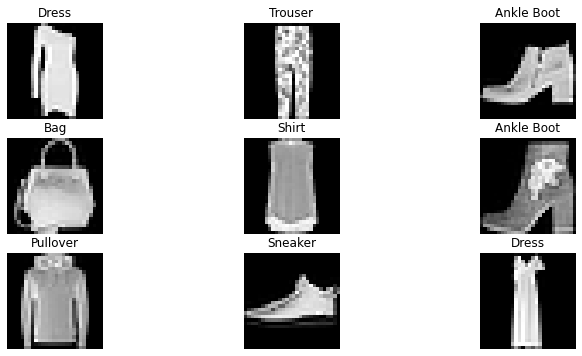

In [25]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(12, 6))
for i in range(1, 10):
  idx = torch.randint(len(training_data), size=(1,)).item()
  img, label = training_data[idx]
  label = torch.argmax(label).item()
  figure.add_subplot(3, 3, i)
  plt.title(labels_map[label])
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Divide on batches 64

In [ ]:
from torch.utils.data import DataLoader
training_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
validation_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

train_sample, train_label = next(iter(training_dataloader))
plt.imshow(train_sample[0].squeeze(), cmap="gray")
plt.title(labels_map[np.argmax(train_label[0]).item()])
plt.axis("off")
plt.show()

Build model. Choose cuda if available

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cpu


Linear -> Linear -> Linear (activation: ReLU)

In [28]:
class NeuralNetwork(torch.nn.Module):
  def __init__(self):
    super(NeuralNetwork, self).__init__()
    self.flatten = torch.nn.Flatten()
    self.linear_relu_stack = torch.nn.Sequential(
        torch.nn.Linear(28*28, 512),
        torch.nn.ReLU(),
        torch.nn.Linear(512, 512),
        torch.nn.ReLU(),
        torch.nn.Linear(512, 10),
        torch.nn.ReLU()
    )

  def forward(self, x):
    x_flatten = self.flatten(x)
    y_logits = self.linear_relu_stack(x_flatten)
    return y_logits
    
model = NeuralNetwork().to(device)

Test work of model on random noise and show result

Predicted class T-Shirt


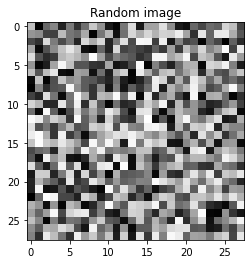

In [29]:
img_rand = torch.rand(1, 28, 28, device=device)
y_logits = model.forward(img_rand)
plt.imshow(img_rand.cpu().numpy().squeeze(), cmap="gray")
plt.title("Random image")
result = torch.nn.Softmax(dim=1)(y_logits)
y_pred = torch.argmax(result).item()
print(f"Predicted class {labels_map[y_pred]}")

See example of simple network with cross-entropy

In [30]:
x = torch.ones(5)
y = torch.tensor([1.])
w = torch.randn(5, requires_grad=True)
b = torch.randn(1, requires_grad=True)
s = torch.matmul(w, x)+ b
result = torch.nn.functional.binary_cross_entropy_with_logits(s, y)
result

tensor(0.0027, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

## Learning

Define aprams

In [31]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

Testing loop function with accuracy and errror

In [34]:
def test_loop(dataloader, model, loss_fn):
    dataset_len = len(dataloader.dataset)
    correct = 0
    error = 0
    with torch.no_grad():
      for X, y in dataloader:
        X = X.to(device)
        pred = model(X)
        y = y.to(device)
        correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
        error += loss_fn(pred, y).item()
      print(f"Accuracy: {correct/dataset_len}, error: {error}")

test_loop(validation_dataloader, model, torch.nn.CrossEntropyLoss())

Accuracy: 0.1185, error: 361.4322807788849


Train model
optimizer - SGD
loss - CrossEntropy

In [35]:
def train_loop(dataloader, model, loss_fn, optimizer):
    dataset_len = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
      X = X.to(device)
      y = y.to(device)
      pred = model(X)
      loss = loss_fn(pred, y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if (batch % 10000 == 0):
        loss, progress = loss_fn(pred, y), batch*len(X)
        print(f"     - Training: loss: {loss}. Progress: {progress}/{dataset_len} ({round(progress*100/dataset_len, 2)}%)")

for epoch in range(epochs):
  print(f"Epoch Number {epoch}")
  train_loop(training_dataloader, model, torch.nn.CrossEntropyLoss(), torch.optim.SGD(model.parameters(), learning_rate))
  print("Testing: ")
  test_loop(validation_dataloader, model, torch.nn.CrossEntropyLoss())

Epoch Number 0
     - Training: loss: 2.302645444869995. Progress: 0/60000 (0.0%)
Testing: 
Accuracy: 0.2729, error: 353.314493894577
Epoch Number 1
     - Training: loss: 2.2709462642669678. Progress: 0/60000 (0.0%)
Testing: 
Accuracy: 0.3433, error: 343.7960295677185
Epoch Number 2
     - Training: loss: 2.1582212448120117. Progress: 0/60000 (0.0%)
Testing: 
Accuracy: 0.3779, error: 332.4918920993805
Epoch Number 3
     - Training: loss: 2.0935065746307373. Progress: 0/60000 (0.0%)
Testing: 
Accuracy: 0.393, error: 321.5255368947983
Epoch Number 4
     - Training: loss: 2.096877098083496. Progress: 0/60000 (0.0%)
Testing: 
Accuracy: 0.3945, error: 308.7107038497925
Epoch Number 5
     - Training: loss: 1.9368432760238647. Progress: 0/60000 (0.0%)
Testing: 
Accuracy: 0.4683, error: 297.4461957216263
Epoch Number 6
     - Training: loss: 1.7837176322937012. Progress: 0/60000 (0.0%)
Testing: 
Accuracy: 0.4455, error: 286.9308692216873
Epoch Number 7
     - Training: loss: 1.838295459747

KeyboardInterrupt: ignored

Save model on disk

In [36]:
torch.save(model.state_dict(), "FashionMNIST.pth")
print("Model trained, evaluated and saved in FashionMNIST.pth")

Model trained, evaluated and saved in FashionMNIST.pth


## Test inference. Load model

In [37]:
model = NeuralNetwork()
model.load_state_dict(torch.load("FashionMNIST.pth"))
model.eval()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)

Pick one sample

SIZE torch.Size([1, 28, 28])


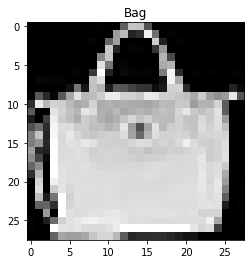

Predicted: * Coat * 
 But real: * Bag *


In [55]:
t = next(iter(validation_dataloader))
img = t[0][0]
label = torch.argmax(t[1][0]).item()
plt.imshow(img.squeeze(), cmap="gray")
plt.title(labels_map[label])
plt.show()
with torch.no_grad():
  model.to(device)
  img = img.to(device)
  pred = model(img)
  print("Predicted: *", labels_map[pred.argmax(1).cpu().item()], "* \n But real: *", labels_map[label], "*")

Draw image here: 

Reference: https://gist.github.com/korakot/8409b3feec20f159d8a50b0a811d3bca

In [ ]:
from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode
import os
from PIL import Image
import cv2

canvas_html = """
<canvas width=%d height=%d></canvas>
<button>Finish</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')
ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}
canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}
var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

def draw(filename='drawing.png', w=400, h=200, line_width=1):
  display(HTML(canvas_html % (w, h, line_width)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return len(binary)

def load_image(image_path='/content/drawing.png'):
    img = Image.open(image_path)
    img = np.array(img)
    img = cv2.resize(img, dsize=(28, 28))
    img = img.mean(2) / 255
    return img


def inference(image_path='/content/drawing.png'):
  img = load_image(image_path)
  img = img.reshape((1, 28, 28))
  img = torch.tensor(img).to(torch.float).to(device)
  model.to(device)
  with torch.no_grad():
    y_pred = model(img)
  return labels_map[pred.argmax(1).cpu().item()]

draw()

print("Model prediction: ", inference())


And load real image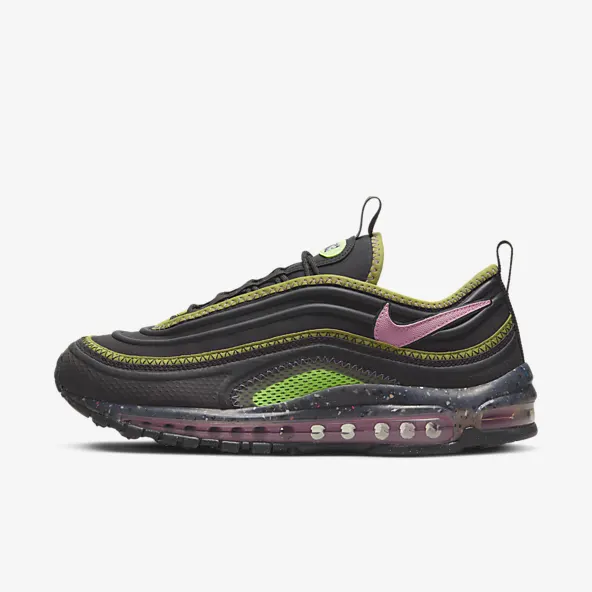

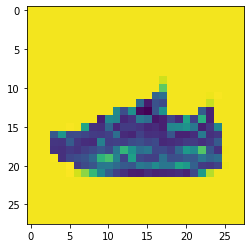

In [94]:
plt.imshow(load_image("/content/shoe.png"))
plt.title("Shoes")
print("Model prediction: ", inference("/content/shoe.png"))

Works correctly!